<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/Test_bench/Test_bench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras,os
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import numpy as np
from tensorflow import keras
from keras.initializers import glorot_uniform


In [2]:
def select_dataset(index):

  if(index==1):
    fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
    (X_train, y_train), (X_test, y_test) = fashion_mnist

  elif(index==2):
    cifar_10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar_10
  
  elif(index==3):
    cifar_100 = tf.keras.datasets.cifar100.load_data()
    (X_train, y_train), (X_test, y_test) = cifar_100

    
  return X_train,y_train,X_test,y_test

In [23]:
def pre_processing_fashion_mnist(X_train,y_train,X_test,y_test,image_channel):
  img_width = X_train.shape[1]
  img_height = X_train.shape[2]
  input_shape = (img_width, img_height, image_channel)
  
  # normalize data
  X_train, X_test = X_train / 255, X_test / 255

  # reshape input 
  X_train = X_train.reshape(X_train.shape[0], *input_shape)
  X_test = X_test.reshape(X_test.shape[0], *input_shape)

  # one-hot
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = tf.keras.utils.to_categorical(y_test)

  return X_train,y_train,X_test,y_test,input_shape

def pre_processing_cifar10(X_train,y_train,X_test,y_test,image_channel):
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  y_train = keras.utils.to_categorical(y_train)
  y_test = keras.utils.to_categorical(y_test)

  X_train, X_test = X_train / 255, X_test / 255

  img_width = X_train[0].shape[0]
  img_height = X_train[0].shape[1]
  image_channel = image_channel

  input_shape=(img_width,img_height,image_channel) 
  print(input_shape)
  return X_train,y_train,X_test,y_test,input_shape
  
def pre_processing_cifar100(X_train,y_train,X_test,y_test,image_channel):
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  y_train = keras.utils.to_categorical(y_train)
  y_test = keras.utils.to_categorical(y_test)

  X_train, X_test = X_train / 255, X_test / 255
  
  img_width = X_train[0].shape[0]
  img_height = X_train[0].shape[1]
  image_channel = image_channel

  input_shape=(img_width,img_height,image_channel) 
  print(input_shape)
  return X_train,y_train,X_test,y_test,input_shape

In [19]:
def define_model_vgg16(image_shape,total_classes):

  model = Sequential()
  model.add(Conv2D(input_shape=image_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=total_classes, activation="softmax"))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  
  return model

def define_model_standard_cnn(image_shape,total_classes):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(total_classes, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
  return model



In [5]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape , total_classes ):   
    
    X_input = Input(input_shape)
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(total_classes, activation='softmax', name='fc' + str(total_classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
def train_model_vgg16(X_train,y_train,X_test,y_test,epochs=10,batch_size=256):
  
  callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_accuracy', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1 )
  ]
  history=model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size,callbacks = callbacks, verbose = 1,validation_data=(X_test,y_test))
  return history

def train_model_standard_cnn(X_train,y_train,X_test,y_test,epochs=10,batch_size=256):

  history=model.fit(X_train , y_train , epochs = epochs , validation_data=(X_test,y_test),batch_size=batch_size)
  return history

def train_model_resnet50(X_train,y_train,X_test,y_test,epochs=10):

  history=model.fit(X_train , y_train , epochs = epochs , validation_data=(X_test,y_test),batch_size=256)
  return history

In [7]:
def make_prediction(model,X_test,index):

  return model.predict(X_test(index))


In [ ]:

'''X_train,y_train,X_test,y_test=select_dataset(1)
X_train,y_train,X_test,y_test,image_shape=pre_processing_fashion_mnist(X_train,y_train,X_test,y_test,1)
model=define_model(image_shape,10)
train_model(X_train,y_train,X_test,y_test)'''

'''X_train,y_train,X_test,y_test=select_dataset(2)
X_train,y_train,X_test,y_test,image_shape=pre_processing_cifar10(X_train,y_train,X_test,y_test,3)
model=define_model_vgg16(image_shape,10)
train_model_vgg16(X_train,y_train,X_test,y_test,epochs=1)
'''
history={}
X_train,y_train,X_test,y_test=select_dataset(3)
X_train,y_train,X_test,y_test,image_shape=pre_processing_cifar100(X_train,y_train,X_test,y_test,3)
model=ResNet50(image_shape,100)
history[('resent','cifar-100')]=train_model_resnet50(X_train,y_train,X_test,y_test,epochs=10)
!mkdir -p saved_model
model.save('saved_model/resent-cifar-100')



(32, 32, 3)
Epoch 1/10
196/196 [==============================] - 42s 182ms/step - loss: 4.2322 - accuracy: 0.0812 - val_loss: 4.8367 - val_accuracy: 0.0267
Epoch 2/10
196/196 [==============================] - 34s 172ms/step - loss: 3.5693 - accuracy: 0.1716 - val_loss: 3.6274 - val_accuracy: 0.1541
Epoch 3/10
196/196 [==============================] - 34s 172ms/step - loss: 3.1358 - accuracy: 0.2445 - val_loss: 3.9824 - val_accuracy: 0.2007
Epoch 4/10
196/196 [==============================] - 34s 172ms/step - loss: 2.8494 - accuracy: 0.2970 - val_loss: 6.7854 - val_accuracy: 0.1913
Epoch 5/10
196/196 [==============================] - 34s 172ms/step - loss: 2.6756 - accuracy: 0.3311 - val_loss: 3.4791 - val_accuracy: 0.2501
Epoch 6/10
196/196 [==============================] - 34s 172ms/step - loss: 2.9014 - accuracy: 0.2921 - val_loss: 3.8662 - val_accuracy: 0.1892
Epoch 7/10
196/196 [==============================] - 34s 172ms/step - loss: 2.3870 - accuracy: 0.3827 - val_loss: 3.0

In [24]:
X_train,y_train,X_test,y_test=select_dataset(2)
X_train,y_train,X_test,y_test,image_shape=pre_processing_cifar10(X_train,y_train,X_test,y_test,3)
model=define_model_vgg16(image_shape,10)
history[('vgg16','cifar-10')]=train_model_vgg16(X_train,y_train,X_test,y_test,epochs=50)

(32, 32, 3)
Epoch 1/50
196/196 [==============================] - 46s 227ms/step - loss: 2.3029 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
Epoch 2/50
196/196 [==============================] - 44s 222ms/step - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/50
196/196 [==============================] - 43s 219ms/step - loss: 2.3027 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00003: val_accuracy did not improve from 0.10000
Epoch 4/50
196/196 [==============================] - 43s 219ms/step - loss: 2.3027 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00004: val_accuracy did not improve from 0.10000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
196/196 [

KeyboardInterrupt: ignored

In [27]:
X_train,y_train,X_test,y_test=select_dataset(2)
X_train,y_train,X_test,y_test,image_shape=pre_processing_cifar10(X_train,y_train,X_test,y_test,3)
model=define_model_standard_cnn(image_shape,10)
history[('cnn','cifar-10')]=train_model_standard_cnn(X_train,y_train,X_test,y_test)

(32, 32, 3)
Epoch 1/10
196/196 [==============================] - 5s 20ms/step - loss: 1.7593 - accuracy: 0.3513 - val_loss: 1.4502 - val_accuracy: 0.4805
Epoch 2/10
196/196 [==============================] - 3s 18ms/step - loss: 1.3521 - accuracy: 0.5129 - val_loss: 1.2729 - val_accuracy: 0.5426
Epoch 3/10
196/196 [==============================] - 3s 18ms/step - loss: 1.2205 - accuracy: 0.5658 - val_loss: 1.1430 - val_accuracy: 0.5974
Epoch 4/10
196/196 [==============================] - 3s 18ms/step - loss: 1.1038 - accuracy: 0.6089 - val_loss: 1.0647 - val_accuracy: 0.6242
Epoch 5/10
196/196 [==============================] - 3s 18ms/step - loss: 1.0256 - accuracy: 0.6384 - val_loss: 1.0463 - val_accuracy: 0.6336
Epoch 6/10
196/196 [==============================] - 3s 18ms/step - loss: 0.9546 - accuracy: 0.6658 - val_loss: 1.0381 - val_accuracy: 0.6410
Epoch 7/10
196/196 [==============================] - 3s 18ms/step - loss: 0.8930 - accuracy: 0.6865 - val_loss: 1.0413 - val_accu

Test loss: 2.9784138202667236 / Test accuracy: 0.3000999987125397


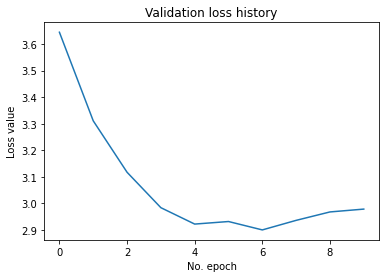

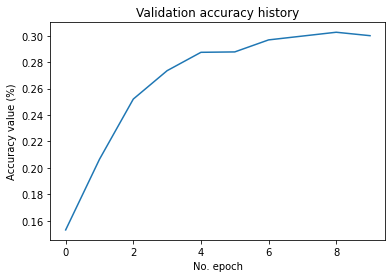

In [ ]:
import matplotlib.pyplot as plt

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
!pip freeze > requirements.txt